<a href="https://colab.research.google.com/github/jldz9/InSARScript/blob/tutorial/InSARScript_Tutorial_v110.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# InSARScript Tutorial
Welcome to InSARScript! InSAR Script is an open-source package designed to support the full InSAR processing pipeline. The primary goal of this package is to provide a streamlined and user-friendly InSAR processing experience across multiple satellite products.

This tutorial will guide you through the essential steps of using InSARScript

## Setup Environment

This step will setup the program environment, this may take several minutes. Runtime restart might be required after installation.

Red warning is due to switching back to numpy 1.26.4 and can be ignored.

In [2]:
from google.colab import drive
drive.mount('/content/drive')
!git clone https://github.com/jldz9/InSARScript.git
!pip install -e /content/InSARScript

Mounted at /content/drive
Cloning into 'InSARScript'...
remote: Enumerating objects: 1080, done.
remote: Counting objects: 100% (288/288), done.
remote: Compressing objects: 100% (165/165), done.
remote: Total 1080 (delta 122), reused 234 (delta 84), pack-reused 792 (from 1)
Receiving objects: 100% (1080/1080), 13.78 MiB | 33.76 MiB/s, done.
Resolving deltas: 100% (522/522), done.
Obtaining file:///content/InSARScript
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.2 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of rasterio to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 78.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.7/35.7 MB 26.5 MB/s



## Account Setup
InSARScript requires multiple online accounts for full functionality. Registration for these accounts is completely free.

Register [NASA Earthdata](https://urs.earthdata.nasa.gov/)

Register [Copernicus Climate Data Store](https://cds.climate.copernicus.eu/)

This account is required for searching satellite scenes, downloading DEMs and orbit files, and submitting online interferogram processing jobs.
Once you've register your account please put your corresponding info below:

`  ⚠️ Note: This tutorial will not store or share your personal information`

In [1]:
Earthdata_Username = 'jldz9asf'
Earthdata_Password = 'Asf5098853!@#'

Once you registered Copernicus Climate Data Store account, Click [Here](https://cds.climate.copernicus.eu/how-to-api) to get your API token.


In [2]:
CCDS_API_Key = 'b1f851fa-5a45-4521-8171-791d334f7ce2'

In [3]:
from pathlib import Path
import os
netrc_path = Path.home() / ".netrc"
# Create netrc file
rc_path = Path.home() / ".cdsapirc"
# Write credentials to ~/.netrc
with open(netrc_path, "w") as f:
    f.write(f"""machine urs.earthdata.nasa.gov
login {Earthdata_Username}
password {Earthdata_Password}
""")

with open(rc_path, "w") as f:
    f.write(f"""url: https://cds.climate.copernicus.eu/api
key: {CCDS_API_Key}
""")


----------------------------------------Initial Setup Finished--------------------------------------

## Modules
The InSAR script is designed with three config-based main modules: **Downloader**, **Processor**, and **Analyzer** to cover the entire InSAR processing workflow:


## Workflow
The basic workflow of InSARScript can be brifely described as:

**Set AOI** --> **Searching** --> **Result Filtering** --> **Interferogram** --> **Time-series Analysis**

### Set AOI

InSARScript allows to define the AOI using **bounding box**, **shapefiles**, or **WKT**:


#### Bounding box

In [4]:
AOI = [-113.05, 37.74, -112.68, 38.00]

#### Shapefiles

In [ ]:
AOI = 'path/to/your/shapefile.shp'

#### WKT

In [ ]:
AOI = 'POLYGON((-113.05 37.74, -113.05 38.00, -112.68 38.00, -112.68 37.74, -113.05 37.74))'

### Searching
Once the AOI is defined, you can perform searches using the Downloader.


In [5]:
from insarscript import Downloader
AOI = [-113.05, 37.74, -112.68, 38.00]
s1 = Downloader.create('S1_SLC', intersectsWith=AOI)
results = s1.search()


This downloader relies on the ASF API. Please ensure you to create an account at https://search.asf.alaska.edu/. 
If a .netrc file is not provide under your home directory, you will be prompt to enter your ASF username and password. 
Check documentation for how to setup .netrc file.

Searching for SLCs....
 -- A total of 995 results found. 

The AOI crosses 18 stacks, you can use .summary() or .footprint() to check footprints and .pick((path_frame)) to specific the stack of scence you would like to download. If use .download() directly will create subfolders under /content for each stack


Your AOI probably spans multiple scenes. To view the search result footprints, you can use:

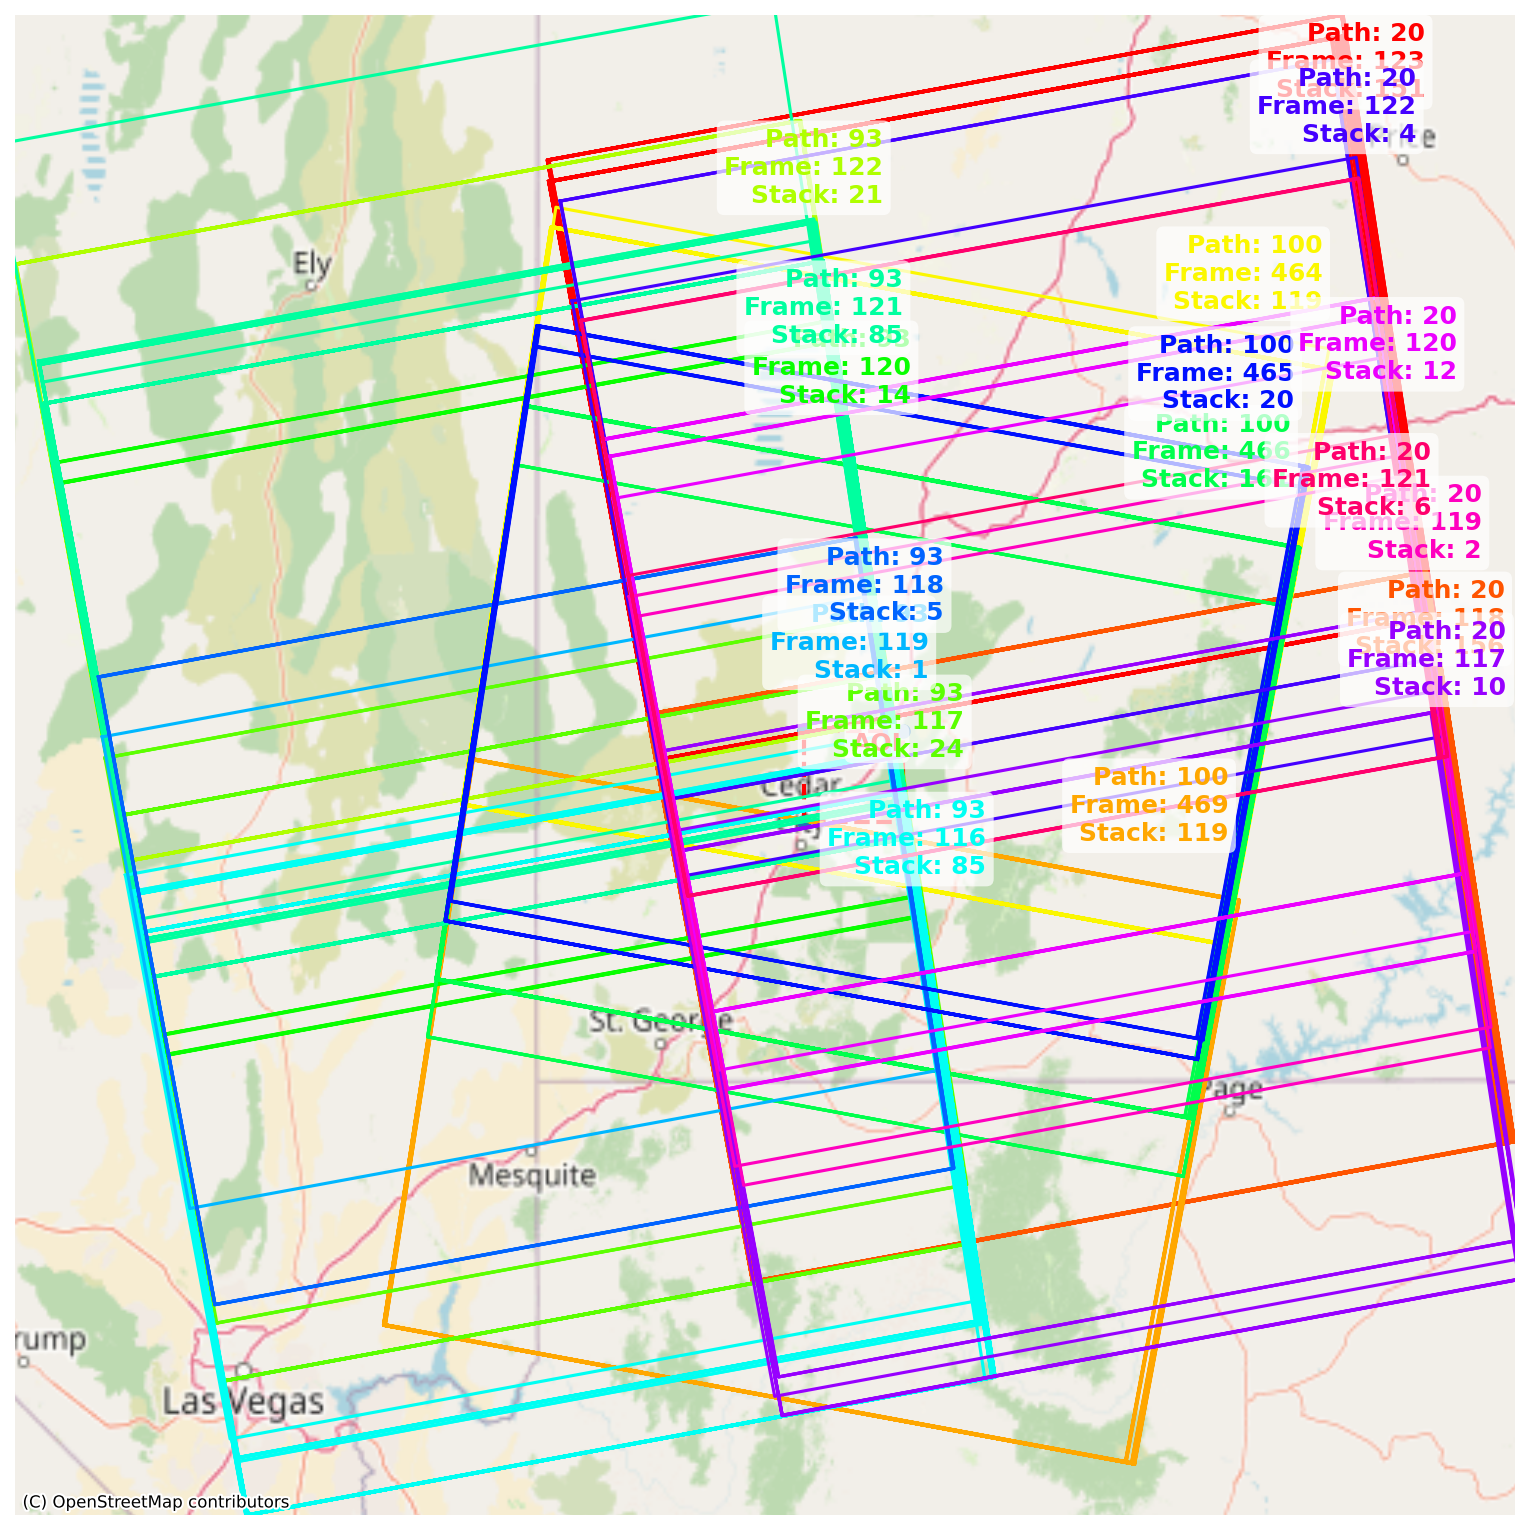

In [6]:
s1.footprint()

This will display a footprint map of the available Sentinel-1 scenes that covers the AOI. The stack indicates numbers of SAR sences in that footprint, becuase we have multiple stacks the graph will be a bit messy:

Let's check details of our SAR sence stacks and figure out which stack(s) we want to keep:

In [7]:
s1.summary()


=== ASCENDING ORBITS (14 Stacks) ===
Path 20 Frame 117 | Count: 10 | 2015-04-05 --> 2016-11-19
Path 20 Frame 118 | Count: 156 | 2016-12-13 --> 2026-02-24
Path 20 Frame 119 | Count: 2 | 2015-03-24 --> 2015-12-25
Path 20 Frame 120 | Count: 12 | 2014-10-31 --> 2016-09-14
Path 20 Frame 121 | Count: 6 | 2015-04-05 --> 2015-08-27
Path 20 Frame 122 | Count: 4 | 2016-05-05 --> 2016-11-19
Path 20 Frame 123 | Count: 151 | 2016-12-13 --> 2026-02-24
Path 93 Frame 116 | Count: 85 | 2014-11-05 --> 2021-12-16
Path 93 Frame 117 | Count: 24 | 2015-03-29 --> 2026-02-17
Path 93 Frame 118 | Count: 5 | 2016-10-07 --> 2017-01-11
Path 93 Frame 119 | Count: 1 | 2017-02-10 --> 2017-02-10
Path 93 Frame 120 | Count: 14 | 2015-11-12 --> 2025-07-04
Path 93 Frame 121 | Count: 85 | 2014-11-05 --> 2021-12-16
Path 93 Frame 122 | Count: 21 | 2025-05-05 --> 2026-02-17

=== DESCENDING ORBITS (4 Stacks) ===
Path 100 Frame 464 | Count: 119 | 2015-11-24 --> 2026-02-23
Path 100 Frame 465 | Count: 20 | 2014-11-29 --> 2017-01

This will output the summary of availiable Sentinel-1 scenes that covers the AOI.

The program identified 18 potential stacks (14 ascending, 4 descending). We can narrowed the dataset to the descending track Path 100, Frame 466 in year 2020 by:

In [8]:
filter_results = s1.filter(path_frame=(100,466), start='2020-01-01', end='2020-12-31')

Filter applied. 1 stacks, 30 total scenes remaining.


Check back the footprint and summary:

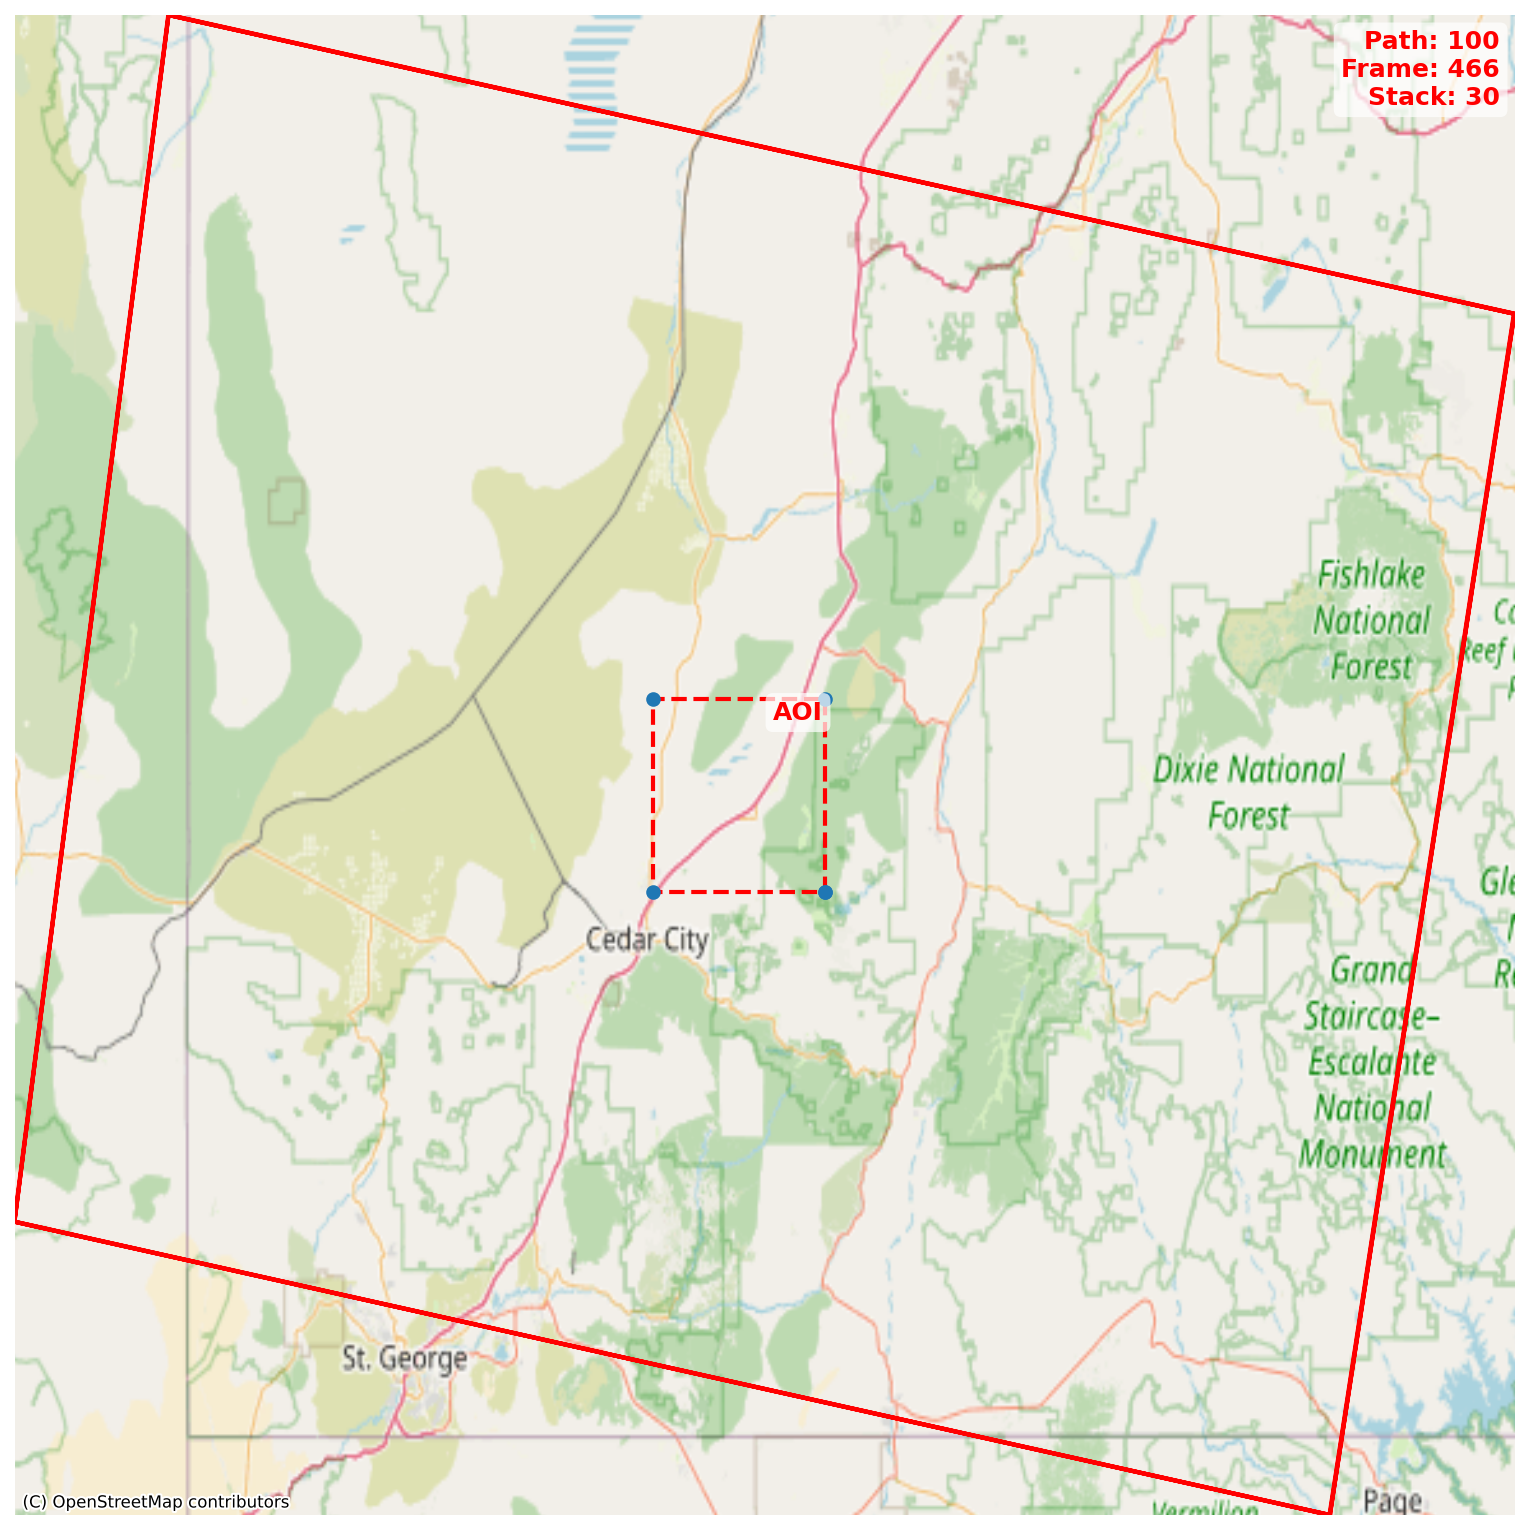


=== DESCENDING ORBITS (1 Stacks) ===
Path 100 Frame 466 | Count: 30 | 2020-01-02 --> 2020-12-27



In [9]:
s1.footprint()
s1.summary()

## Interferogram Process

After locating SAR scene stack(s), the next step is to generate unwrapped interferograms in preparation for the time-series analysis. InSARScript currently support:

- **HyP3**: Use the [HyP3 platform](https://hyp3-docs.asf.alaska.edu/)
 provided by ASF to run the interferometric processing in the cloud and download the resulting interferograms.

InSARSciprt has wrapped [hyp3_sdk](https://github.com/ASFHyP3/hyp3-sdk) as a `Processor`:

Hyp3 InSAR Processor takes a pair of `reference_granule_id` and a `secondary_granule_id` to generate an interferogram. To automate the pair selection process:


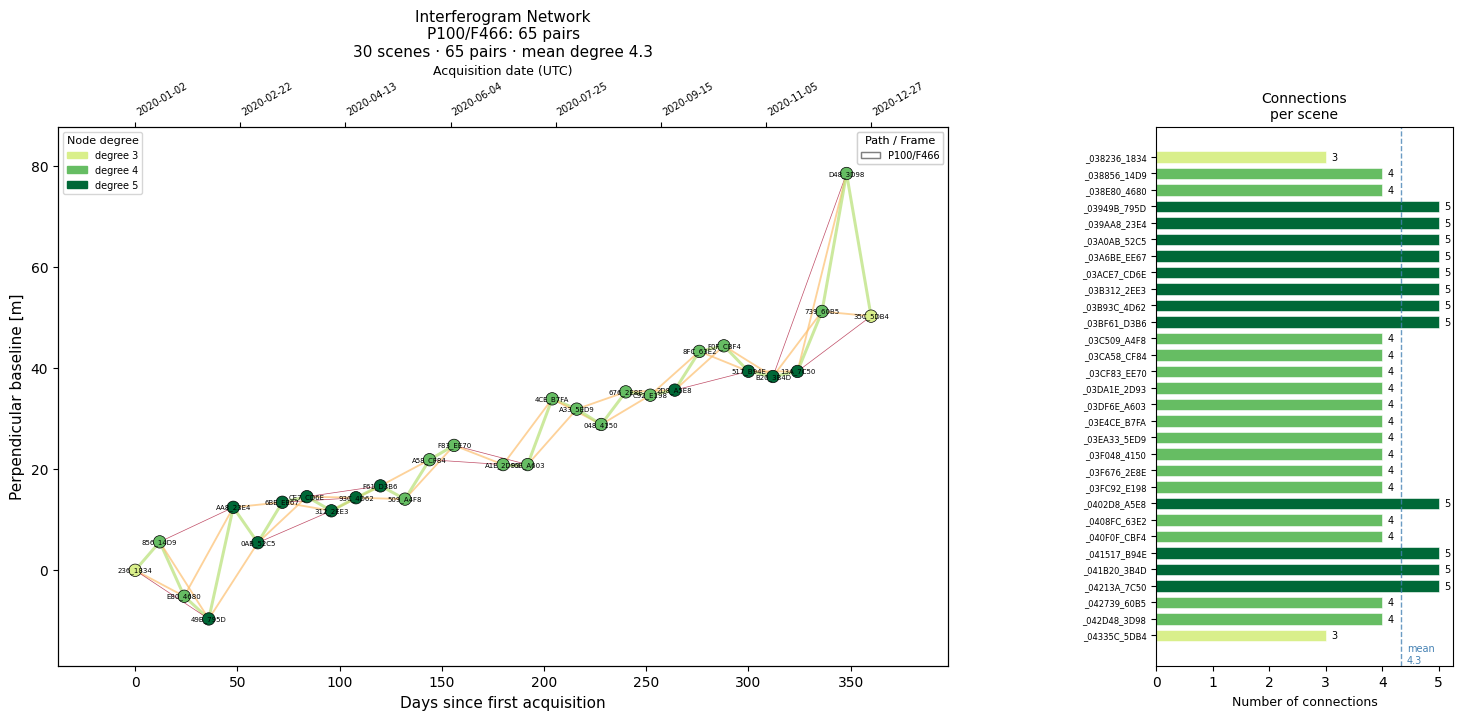

In [12]:
from insarscript.utils import select_pairs, plot_pair_network
pair_stacks, B = select_pairs(filter_results, max_degree=5) # We set the maximum connections to 5 to limit interferograms
fig = plot_pair_network(pair_stacks, B)

If the network is healthy without any disconnections, you are ready to submit your pairs:

In [14]:
from insarscript import Processor
for (path, frame), pairs in pair_stacks.items():
    processor = Processor.create('Hyp3_InSAR', pairs=pairs, workdir=f'/content/drive/MyDrive/')
    batch = processor.submit()
    processor.save()

User jldz9asf: Submitting 65 jobs


Submitting jobs: 100%|██████████| 65/65 [00:09<00:00,  6.96job/s]


All jobs submitted successfully.
Batch file saved under /content/drive/MyDrive/hyp3_jobs.json. Resume later by loading this file path in to saved_job_path.


This process will generate `hyp3_jobs.json` under your work directory, which contains the jobID submitted to the hyp3 server, the processing will take roughly 30 mins for 100 interferograms depends on the ASF server load

The job script will looks like:

In [16]:
import json
with open('/content/drive/MyDrive/hyp3_jobs.json', 'r') as f:
    data = json.load(f)
print(json.dumps(data, indent=4))

{
    "job_ids": {
        "jldz9asf": [
            "20bf9913-a6c6-45e4-8615-714387d5c04d",
            "790c3a75-92d4-4ded-bd9e-37e85ba20526",
            "3a034aa0-391d-4ad0-a033-47893ba683a8",
            "b15f839d-02c1-4152-9f42-6ca028084c21",
            "cd32e602-cf7e-402e-83f6-f3c673e1f04b",
            "ccda167c-eac2-420a-9be2-7035c3cfd920",
            "29dc8e17-69f6-4a77-bdb1-9e2ff4b0db31",
            "ecca462d-04c5-4fdd-a8b0-39ce080cda46",
            "95a3e638-246f-4a99-8490-52fc7a87d7a2",
            "05db4436-f18a-4338-ab63-3b8f8535850c",
            "22ab8e12-e218-4f40-92da-f08638c1d9ed",
            "162c5704-98fd-4444-9372-a95236d21194",
            "9651b573-e88d-49c0-89f2-f0b52651bd9c",
            "2f38e7be-28de-4ea1-b74d-9a206b2c1e93",
            "dd4d4dc0-0eba-48e4-90b3-1a81926a3854",
            "1af22efe-147b-401c-935d-f9c40c672ecd",
            "2809ca1d-737d-454c-b820-aae97702def4",
            "4b9672f0-9c7a-4d59-8d2d-1cf9ba098a0b",
            "e0d9778b-8

To check the job processing status

  - If you still under same session:

In [ ]:
batchs = processor.refresh()

 - If you starts a new session and need to read from saved job file

In [19]:
processor = Processor.create('Hyp3_InSAR', saved_job_path='/content/drive/MyDrive/hyp3_jobs.json')
batchs = processor.refresh()

Loading job IDs from /content/drive/MyDrive/hyp3_jobs.json...

User: jldz9asf (65 jobs)

    JOB NAME                            JOB ID                                 STATUS
  - ifg_20200922T133501_20201028T133501 af160579-ba73-4dcc-a585-d8ad0c7e401d | PENDING
  - ifg_20200910T133501_20200922T133501 325a6afa-5f1d-4609-ba55-a4a7887026eb | PENDING
  - ifg_20200102T133453_20200126T133452 790c3a75-92d4-4ded-bd9e-37e85ba20526 | PENDING
  - ifg_20201121T133501_20201203T133501 9fa230fb-1439-4710-8f35-e2c3ee1924fd | PENDING
  - ifg_20200817T133459_20200829T133500 2810e8ff-65e9-476e-aa98-7c9e65057d31 | PENDING
  - ifg_20201016T133502_20201109T133501 6526a043-f3e0-4ebb-981a-8b3734fbe172 | PENDING
  - ifg_20201203T133501_20201227T133500 de8e80a7-989f-44d2-9762-cf13a2c9d798 | PENDING
  - ifg_20200302T133452_20200314T133452 9651b573-e88d-49c0-89f2-f0b52651bd9c | PENDING
  - ifg_20200302T133452_20200407T133452 dd4d4dc0-0eba-48e4-90b3-1a81926a3854 | PENDING
  - ifg_20200712T133457_20200805T133459 e7

Processing will take roughly 30 mins for every 100 interferograms depends on the ASF server load, once all jobs are completed, use `.download()` to download processed interferograms.

In [21]:
processor.download()

User: jldz9asf (65 jobs)
No succeeded jobs found, skipping.

Download Summary:
  Downloaded : 0
  Skipped    : 0
  Failed     : 0


PosixPath('/content/drive/MyDrive')

Let's pretend the job has completed and download prepared files:

In [4]:
!pip install gdown


In [5]:
!gdown --fuzzy "https://drive.google.com/file/d/1Tef1kLDKEPA11pNt8FhgLRM4aSnwOMTu/view?usp=sharing"
!gdown --fuzzy "https://drive.google.com/file/d/1NvCrDArsNU8zE82pG39vej3oaoXfZVFy/view?usp=sharing"

Downloading...
From (original): https://drive.google.com/uc?id=1Tef1kLDKEPA11pNt8FhgLRM4aSnwOMTu
From (redirected): https://drive.google.com/uc?id=1Tef1kLDKEPA11pNt8FhgLRM4aSnwOMTu&confirm=t&uuid=80c15909-3b87-4a3f-8377-d2ecb3840c97
To: /content/clipped.zip
100% 273M/273M [00:02<00:00, 93.7MB/s]
Downloading...
From: https://drive.google.com/uc?id=1NvCrDArsNU8zE82pG39vej3oaoXfZVFy
To: /content/ERA5.zip
100% 19.4M/19.4M [00:00<00:00, 122MB/s]


In [6]:
!mkdir -p workdir/ERA5
!unzip clipped.zip -d /content/workdir
!unzip ERA5.zip -d /content/workdir

Archive:  clipped.zip
 extracting: /content/workdir/S1AA_20200102T133453_20200114T133453_VVP012_INT80_G_weF_F3CC.zip  
 extracting: /content/workdir/S1AA_20200102T133453_20200126T133452_VVP024_INT80_G_weF_65AB.zip  
 extracting: /content/workdir/S1AA_20200102T133453_20200207T133452_VVP036_INT80_G_weF_A94B.zip  
 extracting: /content/workdir/S1AA_20200114T133453_20200126T133452_VVP012_INT80_G_weF_6694.zip  
 extracting: /content/workdir/S1AA_20200114T133453_20200207T133452_VVP024_INT80_G_weF_03D1.zip  
 extracting: /content/workdir/S1AA_20200114T133453_20200219T133452_VVP036_INT80_G_weF_E34D.zip  
 extracting: /content/workdir/S1AA_20200126T133452_20200207T133452_VVP012_INT80_G_weF_6F4B.zip  
 extracting: /content/workdir/S1AA_20200126T133452_20200219T133452_VVP024_INT80_G_weF_0042.zip  
 extracting: /content/workdir/S1AA_20200207T133452_20200219T133452_VVP012_INT80_G_weF_912B.zip  
 extracting: /content/workdir/S1AA_20200207T133452_20200302T133452_VVP024_INT80_G_weF_DA4B.zip  
 extract

## SBAS

After generated all unwrapped interferograms, time-series analysis is recommended for long term deformation monitoring. InSARScript currently support:

- **Mintpy**: an open-source Python package for InSAR time-series analysis.

InSARSciprt has wrapped Mintpy's SmallbaselineApp as an analyzer, to connect Mintpy with Hyp3 product and run time-series analysis:

(The SBAS process takes roughly 6 minutes to complete)

In [13]:
from insarscript import Analyzer
workdir = '/content/workdir'
hyp3_sbas = Analyzer.create('Hyp3_SBAS', workdir=workdir, troposphericDelay_weatherDir='/content/workdir', reference_lalo='37.8412415,-112.8293839')
hyp3_sbas.prep_data()
hyp3_sbas.run()

Unzipping HyP3 Products...


File Exist: S1AA_20200606T133455_20200630T...: 100%|██████████| 65/65 [00:00<00:00, 240.30file/s]



Unzipping complete.
Mapping file paths...
Found 65 pairs | Metadata: OK
Clipping rasters to common overlap...


Group: water_mask: 100%|██████████| 6/6 [00:02<00:00,  2.78it/s]


Step: Copying metadata files... 
Clipping complete.
Running MintPy Analysis...
Project name: mintpy
Go to work directory: /content/workdir
read custom template file: /content/workdir/mintpy.cfg
update default template based on input custom template
    mintpy.reference.lalo: auto --> 37.8412415,-112.8293839
copy mintpy.cfg           to inputs   directory for backup.
copy smallbaselineApp.cfg to inputs   directory for backup.
copy mintpy.cfg           to pic      directory for backup.
copy smallbaselineApp.cfg to pic      directory for backup.
read default template file: /content/workdir/smallbaselineApp.cfg


******************** step - load_data ********************

load_data.py --template /content/workdir/smallbaselineApp.cfg /content/workdir/mintpy.cfg --project mintpy
processor : hyp3
SAR platform/sensor : unknown from project name "mintpy"
--------------------------------------------------
prepare metadata files for hyp3 products
prep_hyp3.py "/content/workdir/clip/*_unw_phase_cl

To view the mean velocity map

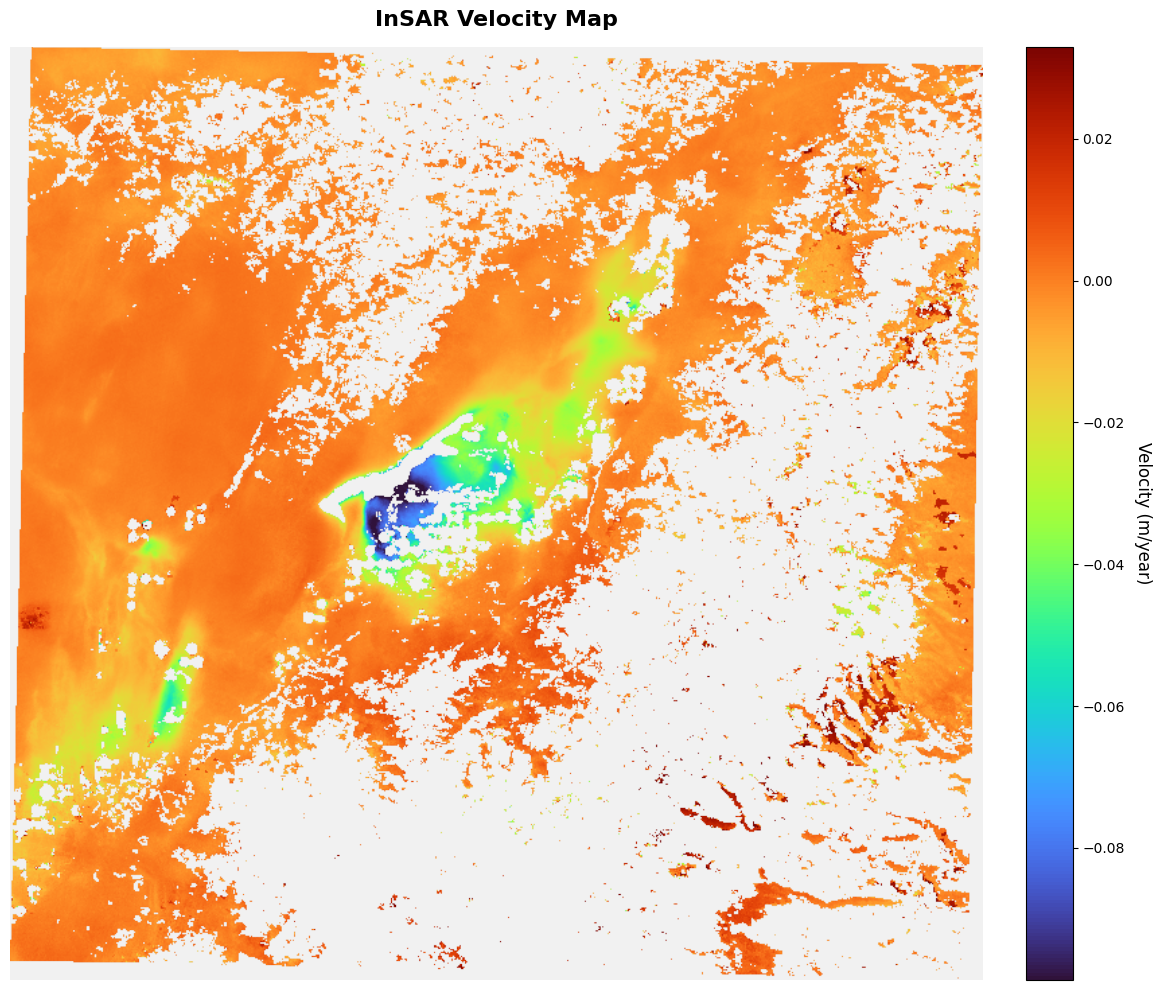

In [21]:
import rasterio
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
from insarscript.utils import h5_to_raster

h5_to_raster('/content/workdir/velocity.h5')
raster_path = '/content/workdir/velocity_velocity.tif'

with rasterio.open(raster_path) as src:
    data = src.read(1)

nodata_value = -9999
data[data == nodata_value] = np.nan

vmin, vmax = np.nanpercentile(data, [0.1, 99.9])

# Create figure with proper layout
fig, ax = plt.subplots(figsize=(12, 10))

# Set bad values (NaN) to appear as light gray
cmap = plt.cm.turbo
cmap.set_bad(color='lightgray', alpha=0.3)

# Plot the data
im = ax.imshow(data, cmap=cmap, vmin=vmin, vmax=vmax, interpolation='bilinear')

# Add colorbar on the right
cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
cbar.set_label('Velocity (m/year)', fontsize=12, rotation=270, labelpad=20)
cbar.ax.tick_params(labelsize=10)

# Styling
ax.set_title('InSAR Velocity Map', fontsize=16, fontweight='bold', pad=15)
ax.axis('off')

plt.tight_layout()
plt.show()

To view the time series of specific location

In [43]:
from ipywidgets import interact, IntSlider
import h5py
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
import rasterio

# Read timeseries data
with h5py.File('/content/workdir/timeseries.h5', 'r') as f:
    timeseries = f['timeseries'][:]
    dates = f['date'][:]

date_list = [datetime.strptime(d.decode() if isinstance(d, bytes) else str(d), '%Y%m%d')
             for d in dates]
timeseries[timeseries == -9999] = np.nan

# Read velocity map
with rasterio.open('/content/workdir/velocity_velocity.tif') as src:
    velocity = src.read(1)

velocity[velocity == -9999] = np.nan

# Set your custom default values here
DEFAULT_X = 313  # Change this to your desired X pixel
DEFAULT_Y = 318  # Change this to your desired Y pixel

@interact(
    x=IntSlider(
        min=0,
        max=timeseries.shape[2]-1,
        value=DEFAULT_X,
        description='X pixel:'
    ),
    y=IntSlider(
        min=0,
        max=timeseries.shape[1]-1,
        value=DEFAULT_Y,
        description='Y pixel:'
    )
)
def plot_at_pixel(x, y):
    ts = timeseries[:, y, x]

    # Make timeseries start from 0 (relative to first date)
    ts_normalized = ts - ts[0]

    fig, axes = plt.subplots(1, 2, figsize=(16, 5))

    # Timeseries
    axes[0].plot(date_list, ts_normalized, 'o-', linewidth=2.5, markersize=7,
                 color='steelblue', markeredgecolor='navy')
    axes[0].axhline(y=0, color='red', linestyle='--', alpha=0.5, linewidth=2)
    axes[0].grid(True, alpha=0.3)
    axes[0].set_xlabel('Date', fontsize=12, fontweight='semibold')
    axes[0].set_ylabel('Displacement (m)', fontsize=12, fontweight='semibold')
    axes[0].set_title(f'Timeseries at pixel ({x}, {y})', fontsize=14, fontweight='bold')
    axes[0].tick_params(axis='x', rotation=45)

    # Add stats box
    mean_disp = np.nanmean(ts_normalized)
    std_disp = np.nanstd(ts_normalized)
    final_disp = ts_normalized[-1]
    axes[0].text(0.02, 0.98,
                f'Mean: {mean_disp:.2f} m\nStd: {std_disp:.2f} m\nFinal: {final_disp:.2f} m',
                transform=axes[0].transAxes, fontsize=10, verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.7))

    # Velocity map
    vmin, vmax = np.nanpercentile(velocity, [0.1, 99.9])
    cmap = plt.cm.turbo
    cmap.set_bad(color='lightgray', alpha=0.3)

    im = axes[1].imshow(velocity, cmap=cmap, vmin=vmin, vmax=vmax, interpolation='bilinear')
    axes[1].plot(x, y, 'w*', markersize=22, markeredgewidth=2.5, markeredgecolor='black')
    axes[1].set_title('Mean Velocity Map', fontsize=14, fontweight='bold')
    axes[1].axis('off')

    cbar = plt.colorbar(im, ax=axes[1], fraction=0.046, pad=0.04)
    cbar.set_label('Velocity (m/year)', fontsize=11, rotation=270, labelpad=20)
    cbar.ax.tick_params(labelsize=10)

    plt.tight_layout()
    plt.show()

interactive(children=(IntSlider(value=313, description='X pixel:', max=722), IntSlider(value=318, description=…